In [32]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from scipy.stats import trim_mean
from sklearn.metrics import mean_squared_error
import collections

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

sys.path.append('..')
from higgs_inference import settings
from higgs_inference.various.utils import format_number


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings

In [33]:
colors     = ['darkgreen',  'mediumblue',  'c', '#CC002E', '#be96ff']
linestyles = [       '--',       '-.',     ':',         '--',          '-.']
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]


In [34]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.08
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Data

In [35]:
result_dir = '../results/'

def expected_mse_log_r(filename, folder='parameterized'):
    mse_log_r = np.load(result_dir + folder + '/mse_logr_' + filename + '.npy')
    return np.sum(settings.theta_prior * mse_log_r)
                       
def expected_trimmed_mse_log_r(filename, folder='parameterized'):
    mse_log_r = np.load(result_dir + folder + '/trimmed_mse_logr_' + filename + '.npy')
    return np.sum(settings.theta_prior * mse_log_r)


In [36]:
def load_data(filename_reduced, filename_full, folder,
              sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000,
                              1000000, 2000000, 5000000],
              sample_size_full = 10000000):
    
    results_metrics = []
    results_samplesize = []
    
    print('')
    print('Strategy', filename_full)
    
    for ss in sample_sizes:
        try:
            this_filename = filename_reduced.replace('%s', str(ss))
            results_metrics.append(expected_trimmed_mse_log_r(this_filename, folder))
            results_samplesize.append(ss)
            print(' ', ss, results_metrics[-1])
        except IOError:
            pass
        
    try:
        results_metrics.append(expected_trimmed_mse_log_r(filename_full, folder))
        results_samplesize.append(sample_size_full)
        print(' ', 'full', results_metrics[-1])
    except IOError:
        pass
    
    return results_samplesize, results_metrics


In [41]:
mse = []
sample_sizes = []

labels = ['CARL',
          'Ratio regression',
          'Local score regr.',
          'CARL + score regr.',
          'Ratio + score regr.']

filenames_full = ['carl_calibrated_shallow',
                  'regression_calibrated',
                  'scoreregression_rotatedscore_deep',
                  'combined_calibrated_deep',
                  'combinedregression_calibrated_deep']
filenames = ['carl_shallow_trainingsamplesize_%s',
             'regression_trainingsamplesize_%s',
             'scoreregression_rotatedscore_deep_trainingsamplesize_%s',
             'combined_deep_trainingsamplesize_%s',
             'combinedregression_deep_trainingsamplesize_%s']
folders = ['parameterized',
           'parameterized', 
           'score_regression',
           'parameterized', 
           'parameterized']

for filename, filename_full, folder in zip(filenames, filenames_full, folders):
    _sample_sizes, _mse = load_data(filename, filename_full, folder)
    sample_sizes.append(_sample_sizes)
    mse.append(_mse)
    
n_strategies = len(labels)
    


Strategy carl_calibrated_shallow
  1000 249.62734312213396
  2000 366.16011056955244
  full 0.002590348921581731

Strategy regression_calibrated
  1000 0.25129303328378466
  2000 0.21429529582787035
  full 0.0016589920167323809

Strategy scoreregression_rotatedscore_deep
  1000 0.01052238810060782
  2000 0.00533795325894687
  5000 0.0018018123831613534
  10000 0.0007496992193102035
  20000 0.0005735889768945621
  50000 0.00046305624652576355
  100000 0.0002897404971063508
  200000 0.0002804694096732581
  500000 0.0002801217263287188
  1000000 0.0002571059392926373
  full 0.00024740828124700937

Strategy combined_calibrated_deep
  1000 536.7846449292553
  2000 125.81763395297473
  full 0.00024359676001275364

Strategy combinedregression_calibrated_deep
  full 0.00037336005220956685


# Plot

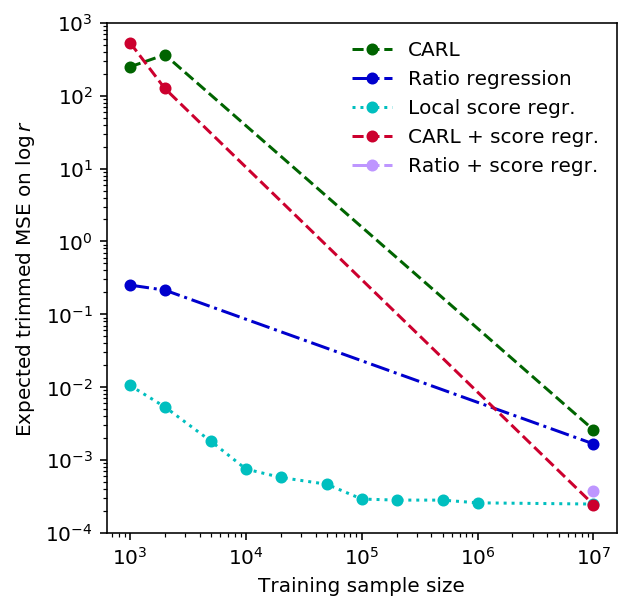

In [42]:
xmin, xmax = -8., 32.
skip = 2

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5)))
ax = plt.gca()

for s in range(n_strategies):
    plt.plot(sample_sizes[s], mse[s],
             ms=5., marker='o',
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s],
             label=labels[s])

plt.legend(loc='upper right', frameon=False)

ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
#plt.xlim(xmin, xmax)
plt.ylim(1.e-4, 1.e3)
plt.xlabel(r"Training sample size")
plt.ylabel(r"Expected trimmed MSE on $\log \, r$")

adjust_margins(1,4.5)
plt.savefig("../figures/paper/training_sample_size.pdf")
